# How to run a Python function on a remote computer

## Introduction

The `PythonJob` node is a built-in node that allows users to run Python functions on a remote computer. It is designed to enable users from non-AiiDA communities to run their Python functions remotely and construct workflows with checkpoints, maintaining all data provenance. For instance, users can use ASE's calculator to run a DFT calculation on a remote computer directly. Users only need to write normal Python code, and the WorkGraph will handle the data transformation to AiiDA data.

### Key Features

1. **Remote Execution**: Seamlessly run Python functions on a remote computer.
2. **User-Friendly**: Designed for users who are not familiar with AiiDA, simplifying the process of remote execution.
3. **Workflow Management**: Construct workflows with checkpoints, ensuring that intermediate states and results are preserved.
4. **Data Provenance**: Maintain comprehensive data provenance, tracking the full history and transformations of data.


Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.

We set `run_remotely` to `True` when adding the node. This will tell the engine that the job is a `Pythonjob` node and should be run on a remote computer.


In [2]:
from aiida_workgraph import node, WorkGraph

# define add node
@node()
def add(x, y):
    return x + y

# define multiply node
@node()
def multiply(x, y):
    return x*y

wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply", x=wg.nodes["add"].outputs[0], run_remotely=True)

# visualize the workgraph
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

### Prepare the inputs and submit the workgraph


**Code**: We can set the `computer` to the remote computer where we want to run the job. This will create a code `python3@computer` if it does not already exist. You can also set the `code` directly if you have already created the code.

**Data**: Users are recommended to use normal Python data as input. The workgraph will handle the transfer and serialization of data to AiiDA data. When serializing to AiiDA data, the workgraph will first search for the corresponding AiiDA data entry point based on the module name and class name (e.g., `ase.atoms.Atoms`). If the corresponding entry point exists, it will be used to serialize the value. If not found, `GeneralData` (pickle) will be used to serialize the value into binary data.

**Python Version**: Since pickle is used to store and load data, the Python version on the remote computer should match the one used on the localhost. You can use conda to create a virtual environment with the same Python version. Activate the environment before running the script.

For real applications, you can pass metadata to the scheduler to activate the conda environment:

```python
metadata = {
    "options": {
        'custom_scheduler_commands': 'module load anaconda\nconda activate py3.11\n',
    }
}
```

WorkGraph node created, PK: 45039

Result of multiply is uuid: 133c1d08-d1b8-459b-bd61-71fc3e6be5ea (pk: 45056) value: 20 




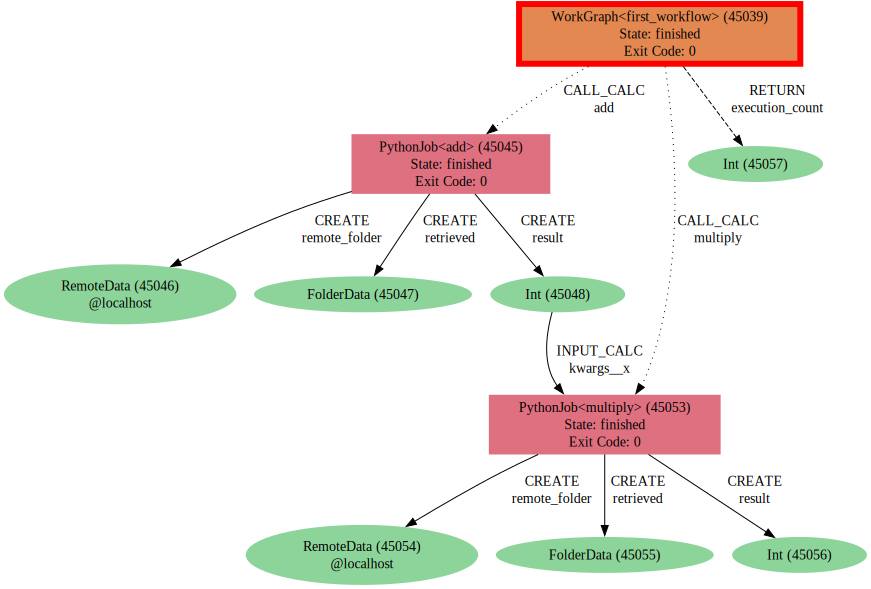

In [3]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Submit the calculation -------------------
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        # 'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
        'custom_scheduler_commands' : '',
    }
}

wg.submit(inputs = {"add": {"x": 2, "y": 3,
                            "computer": "localhost",
                            "metadata": metadata},
                    "multiply": {"y": 4,
                                 "computer": "localhost",
                                 "metadata": metadata}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Use parent folder
The parent_folder parameter allows a node to access the output files of a parent node. This feature is particularly useful when you want to reuse data generated by a previous computation in subsequent computations. In the following example, the multiply node uses the `result.txt` file created by the add node.


In [4]:
from aiida_workgraph import WorkGraph, node

# define add node
@node()
def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))

# define multiply node
@node()
def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply",
             parent_folder=wg.nodes["add"].outputs["remote_folder"],
             run_remotely=True,
             )

#------------------------- Submit the calculation -------------------
display(wg)
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"x": 3, "y": 4, "computer": "localhost"}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

WorkGraph node created, PK: 45058

Result of multiply is uuid: cbd38649-e9eb-4fef-b526-cdb575d3a301 (pk: 45076) value: 17 




## Upload files or folders to the remote computer
The `upload_files` parameter allows users to upload files or folders to the remote computer. The files will be uploaded to the working directory of the remote computer.



In [6]:
from aiida_workgraph import WorkGraph, node

# create a temporary file "input.txt" in the current directory
with open("input.txt", "w") as f:
    f.write("2")

# create a temporary folder "inputs_folder" in the current directory
# and add a file "another_input.txt" in the folder
import os
os.makedirs("inputs_folder", exist_ok=True)
with open("inputs_folder/another_input.txt", "w") as f:
    f.write("3")

# define add node
@node()
def add():
    with open("input.txt", "r") as f:
        a = int(f.read())
    with open("inputs_folder/another_input.txt", "r") as f:
        b = int(f.read())
    return a + b


wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)

#------------------------- Submit the calculation -------------------
# we need use full path to the file
input_file = os.path.abspath("input.txt")
input_folder = os.path.abspath("inputs_folder")

wg.submit(inputs = {"add": {
                            "computer": "localhost",
                            "upload_files": {"input.txt": input_file,
                                             "inputs_folder": input_folder,
                                             },
                            },
                    },
          wait=True)
print("\nResult of add is {} \n\n".format(wg.nodes["add"].outputs['result'].value))

WorkGraph node created, PK: 45089

Result of add is uuid: 6124e4ec-beac-44ea-9d00-baf0402200c1 (pk: 45098) value: 5 




## First Real-world Workflow: atomization energy of molecule

The atomization energy, $\Delta E$, of a molecule can be expressed as:

$$
\Delta E = n_{\text{atom}} \times E_{\text{atom}} - E_{\text{molecule}}
$$

Where:
- $\Delta E$ is the atomization energy of the molecule.
- $n_{\text{atom}}$ is the number of atoms.
- $E_{\text{atom}}$ is the energy of an isolated atom.
- $E_{\text{molecule}}$ is the energy of the molecule.


### Define a node to calculate the energy of the atoms using EMT potential

In [7]:
from aiida_workgraph import node, WorkGraph

@node()
def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return energy


@node()
def atomization_energy(mol, energy_molecule, energy_atom):
    energy = energy_atom*len(mol) - energy_molecule
    return energy


### Define a workgraph


In [8]:
wg = WorkGraph("atomization_energy")
pw_atom = wg.nodes.new(emt, name="emt_atom", run_remotely=True)
pw_mol = wg.nodes.new(emt, name="emt_mol", run_remotely=True)
# create the node to calculate the atomization energy
wg.nodes.new("PythonJob", function=atomization_energy, name="atomization_energy",
             energy_atom=pw_atom.outputs["result"],
             energy_molecule=pw_mol.outputs["result"])
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'atomiza…

### Prepare the inputs and submit the workflow

WorkGraph node created, PK: 45100
Energy of a N atom:                  5.100
Energy of an un-relaxed N2 molecule: 0.549
Atomization energy:                  9.651 eV


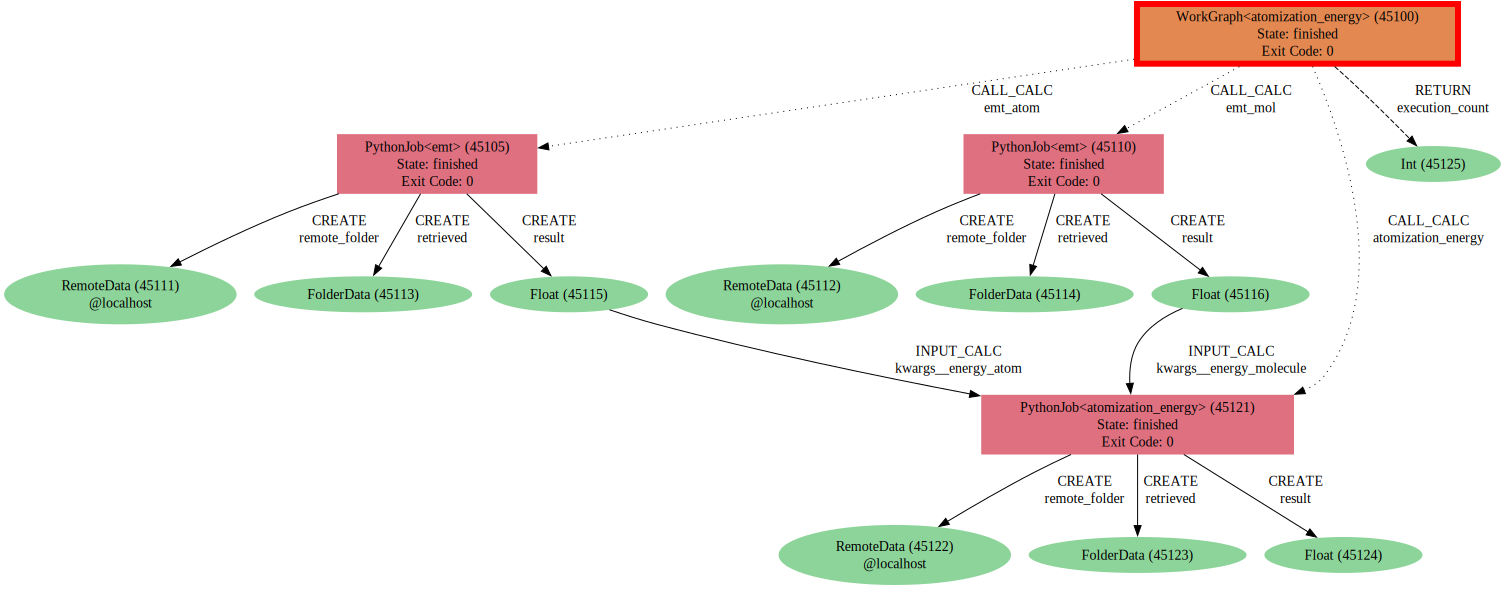

In [9]:
from ase.build import molecule
from ase import Atoms

load_profile()

# create input structure node
n_atom = Atoms("N", pbc=True)
n_atom.center(vacuum=5.0)
n2_molecule = molecule("N2", pbc=True)
n2_molecule.center(vacuum=5.0)


#------------------------- Set the inputs -------------------------
wg.nodes["emt_atom"].set({"atoms": n_atom, "computer": "localhost"})
wg.nodes["emt_mol"].set({"atoms": n2_molecule, "computer": "localhost"})
wg.nodes["atomization_energy"].set({"mol": n2_molecule, "computer": "localhost"})
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of a N atom:                  {:0.3f}'.format(wg.nodes['emt_atom'].outputs["result"].value.value))
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(wg.nodes['emt_mol'].outputs["result"].value.value))
print('Atomization energy:                  {:0.3f} eV'.format(wg.nodes['atomization_energy'].outputs["result"].value.value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)


## Call shell commands in the PythonJob node

We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-workgraph and the `PythonJob` node, this can be run through AiiDA with the following workgraph:

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

WorkGraph node created, PK: 45126

Result of multiply is uuid: 37925251-31c3-40e2-b2db-e308278af0ab (pk: 45143) value: 20.0 




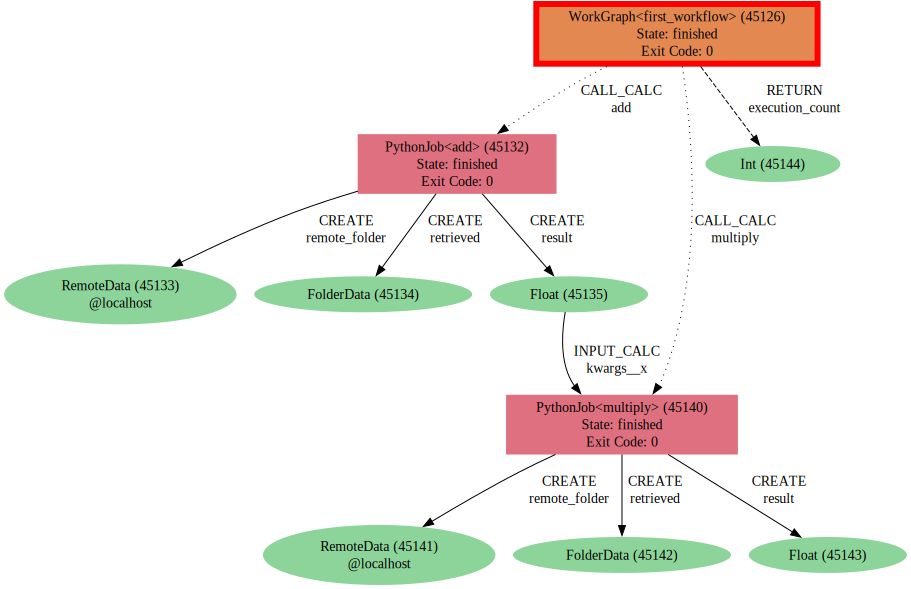

In [10]:
from aiida_workgraph import  node, WorkGraph

@node()
def add(x, y):
    import os
    os.system("echo '{} + {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


@node()
def multiply(x, y):
    import os
    os.system("echo '{} * {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply", x=wg.nodes["add"].outputs[0], run_remotely=True)

# visualize the workgraph
display(wg)

#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"y": 4, "computer": "localhost"}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)